# Loading GHN-3 and Predicting Parameters for all PyTorch ImageNet models 

## Paper: Can We Scale Transformers to Predict Parameters of Diverse ImageNet Models?  https://arxiv.org/abs/2303.04143 

**ICML 2023**

Authors: Boris Knyazev, Doha Hwang, Simon Lacoste-Julien

## 1. Install ppuda (optional, if not installed yet)

In [ ]:
# Copyright (c) 2023. Samsung Electronics Co., Ltd.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

!pip install git+https://github.com/facebookresearch/ppuda.git
!pip show ppuda

In [5]:
# Import required modules
import inspect
import sys
import os
import types
import time
import json
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import joblib
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

sys.path.append(os.path.abspath(os.path.join('..')))  # to import ghn3 from the root folder
from ghn3 import from_pretrained, get_metadata, Graph


print('torch', torch.__version__)
print('torchvision', torchvision.__version__)
print('Make sure PyTorch: >= 1.12.1 and Torchvision >= 0.13.1 are installed to make our code work properly')

torch 2.0.1+cu117
torchvision 0.15.2+cu117
Make sure PyTorch: >= 1.12.1 and Torchvision >= 0.13.1 are installed to make our code work properly


## 2. Load GHN-3

As the largest and best performing GHN-3 model (`ghn3xlm16`) takes about 2.5GB, it takes a while to download the model.

The model is downloaded from HuggingFace: https://huggingface.co/SamsungSAILMontreal/ghn3/tree/main.

We made four main GHN-3 variants from our paper available: `ghn3tm8, ghn3sm8, ghn3lm8, ghn3xlm16`.

We also released other GHN-3 variants such as ablations at https://huggingface.co/SamsungSAILMontreal/ghn3/tree/main/other.

In [2]:
ghn3_name = 'ghn3xlm16.pt'
ghn = from_pretrained(ghn3_name)  # one of 'ghn3tm8.pt', 'ghn3sm8.pt', 'ghn3lm8.pt', 'ghn3xlm16.pt' (default)
print('loading %s with %d parameters is done!' % (ghn3_name, sum([p.numel() for p in ghn.parameters()])))

loading ghn3xlm16.pt with 654365184 parameters is done!


## 3. Predict parameters for ResNet-50 and compare to the downloaded ResNet-50 for sanity check

Parameter prediction for ResNet-50 done in 3.385 seconds on cpu


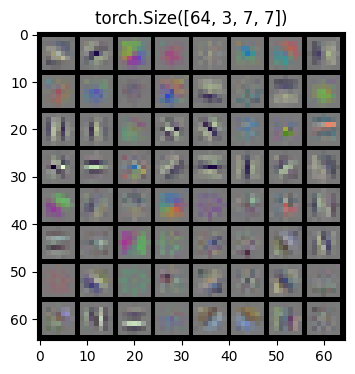

Sanity check on ResNet-50 is done!


In [3]:
device = 'cpu'  # let's do everything on cpu because it's fast anyway

fine_tuning = True  # true if predicted parameters will be fined or false for direct evaluation of predicted parameters

model = models.resnet50()
graph = Graph(model)
# graph.visualize()  # to visualize ResNet-50 graph
start = time.time()
model = ghn(model, graph, bn_track_running_stats=fine_tuning, keep_grads=False)
print('Parameter prediction for ResNet-50 done in %.3f seconds on %s' % (time.time() - start, device))

weights = model.conv1.weight.data.cpu()
grid = torchvision.utils.make_grid(weights, nrow=8, normalize=True, padding=1)
plt.figure(figsize=(4, 4))
plt.title(weights.shape)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()

model_sanity_check = models.resnet50()
model_sanity_check.load_state_dict(joblib.load(hf_hub_download(repo_id='SamsungSAILMontreal/ghn3',
                                                               filename='resnet50_ghn3xlm16_init.pt'))['state_dict'])

dict1 = dict(model.named_parameters())
for n, p in model_sanity_check.named_parameters():
    if not torch.allclose(p, dict1[n], atol=1e-6):
        print('warning: big discrepancy {:.3e} for param: {}'.format(torch.norm(p - dict1[n]), n))        

print('Sanity check on ResNet-50 is done!')        

## 4. Predict parameters for all PyTorch models

In [4]:
norms = get_metadata(ghn3_name, attr='paramnorm')

# Enumerate all PyTorch models of ImageNet classification
# Should be >= 74 models in torchvision>=0.13.1
all_torch_models = []
for m in dir(models):
    if m[0].isupper() or m.startswith('_') or m.startswith('get') or m == 'list_models' or \
      not inspect.isfunction(eval('models.%s' % m)):
        continue
    
    if m not in norms:
        print('=== %s was not in PyTorch at the moment of GHN-3 evaluation, so skipping it in this notebook ===' 
              % m.upper())
        continue  # skip for consistency with the paper

    all_torch_models.append(m)
    
print('\n%d PyTorch models found. Predicting parameters for all...' % len(all_torch_models))    

fine_tuning = True  # true if predicted parameters will be fined or false for direct evaluation of predicted parameters
start_all = time.time()
norms_matched = []
for m_ind, m in enumerate(all_torch_models):
    kw_args = {'init_weights': False} if m in ['googlenet', 'inception_v3'] else {}

    # Predict parameters
    model = eval(f'models.{m}(**kw_args)')
    
    if not isinstance(model, torch.nn.Module):
        print('skipping %s, because it is not torch.nn.Module' % m)
        continue
        
    n_params = sum([p.numel() for p in model.parameters()]) / 10**6
    if m == 'inception_v3':
        model.expected_input_sz = 299
    print('{}/{}: {} with {:.2f}M params'.format(m_ind + 1, 
                                                 len(all_torch_models),
                                                 m.upper(), 
                                                 n_params), end='...')
    start = time.time()
    try:
        model = ghn(model, bn_track_running_stats=fine_tuning, keep_grads=False)
    except Exception as e:
        print('ERROR for model %s: %s' % (m, e))
        continue
    
    total_norm = torch.norm(torch.stack([p.norm() for p in model.parameters()]), 2)
    norms_matched.append(abs(norms[m] - total_norm.item()) < 1e-2)
    print('done in {:.2f} sec, total param norm={:.2f} ({})'.
          format(time.time() - start,
                 total_norm.item(),
                 'norms matched' if norms_matched[-1] else ('ERROR: norm not matched with %.2f' % norms[m])))
        
    # "WARNING: number of predicted ..." means that some layers in the model are not supported by the GHN
    # unsupported modules are initialized using built-in PyTorch methods

print('\ndone for {} models in {:.2f} seconds, norms matched for {} models'.format(len(norms_matched), 
                                                                                   time.time() - start_all,
                                                                                   sum(norms_matched)))


=== MAXVIT_T was not in PyTorch at the moment of GHN-3 evaluation, so skipping it in this notebook ===
=== REGNET_Y_128GF was not in PyTorch at the moment of GHN-3 evaluation, so skipping it in this notebook ===
=== SWIN_V2_B was not in PyTorch at the moment of GHN-3 evaluation, so skipping it in this notebook ===
=== SWIN_V2_S was not in PyTorch at the moment of GHN-3 evaluation, so skipping it in this notebook ===
=== SWIN_V2_T was not in PyTorch at the moment of GHN-3 evaluation, so skipping it in this notebook ===
=== VIT_H_14 was not in PyTorch at the moment of GHN-3 evaluation, so skipping it in this notebook ===

74 PyTorch models found. Predicting parameters for all...
1/74: ALEXNET with 61.10M params...done in 2.05 sec, total param norm=72.48 (norms matched)
2/74: CONVNEXT_BASE with 88.59M params...done in 7.43 sec, total param norm=355.19 (norms matched)
3/74: CONVNEXT_LARGE with 197.77M params...done in 6.67 sec, total param norm=399.83 (norms matched)
4/74: CONVNEXT_SMALL w